In [538]:
import numpy as np
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import functional as F

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [12]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(url).text

# unique chars
chars = sorted(list(set(text)))
vocab_size = len(chars)

In [17]:
print(text[:100])
print("chars:", "".join(chars))
print("vocab size:", vocab_size)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
chars: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [20]:
# we are using character level tokenization
# each unique char is mapped to an integer id

char_to_id = {ch: i for i, ch in enumerate(chars)}
id_to_char = {i: ch for i, ch in enumerate(chars)}

def encode(text: str) -> list[int]:
    return [char_to_id[ch] for ch in text]

def decode(encoded_tokens: list[int]) -> str:
    return "".join(id_to_char[i] for i in encoded_tokens)

In [21]:
print(encode("hi there!"))

[46, 47, 1, 58, 46, 43, 56, 43, 2]


In [22]:
print(decode(encode("hi there!")))

hi there!


In [28]:
# store the tokenized text as a 1d tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:10])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


In [29]:
# first 90% of the text is train dataset, last 10% is the validation
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [31]:
# we are not training the model on entire dataset at once, we split the data into blocks (chunks)
block_size = 8  # also known as context length
# a single block has multiple training samples
# sample 1: predict the next token at the first position ( x = 18 -> y = 47)
# sample 2: predict the next token at the second position (x = 18, 47 -> y = 56)
# sample 3: predict the next token at the third position (x = 18, 47, 56 -> y = 57)

# in block with size 8 there are 7 training samples
print(train_data[:block_size + 1])

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])


In [32]:
# it's useful to train the model on samples with different context length
# the model then can predict next token based on input between 1 up to the block size (context length)
# for input > block size, we start truncating
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [110]:
torch.manual_seed(1337)
block_size = 8  # max context length for predictions
batch_size = 4  # how many sequences to proccess in parallel, 4 blocks in one batch

def get_batch(split: str) -> tuple[torch.Tensor, torch.Tensor]:
    data = train_data if split == "train" else val_data
    # generate 4 random starting positions
    # e.g. tensor([ 325426,  937387, 1057275, 1089260])
    # each integer is the starting index of a block in the data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # generate the 4 blocks and stack them in a tensor
    # shape (4, 8)
    x = torch.stack([data[i:i + block_size] for i in ix])
    # generate the same sequences shifted by one to create the next token targets
    # shape (4, 8) (same as x)
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [51]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [52]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 58, 46] the target: 39
when input is [44, 53, 56, 1, 58, 46, 39] the target: 58
when input is [44, 53, 56, 1, 58, 46, 39, 58] the target: 1
when input is [52] the target: 58
when input is [52, 58] the target: 1
when input is [52, 58, 1] the target: 58
when input is [52, 58, 1, 58] the target: 46
when input is [52, 58, 1, 58, 46] the target: 39
when input is [52, 58, 1, 58, 46, 39] the t

## Bigram Model Baseline

In [111]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size: int):
        super().__init__()
        # bigram model -> context length = 1, one character predicts the next one
        # the embedding table will store the next token prediction logit for each token-token pair in the vocabulary
        # token_embedding_table[54] -> [0.1, 0.4, 0.8,... 0.4] (next token logits for every token in the vocabulary)
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx shape (batch_size, block_size)
        # targets shape (batch_size, block_size)
        # retrieves the next token prediction logits for each token in the sequence
        logits = self.token_embedding_table(idx)
        # logits shape = (batch_size, block_size, vocab_size) = logits for every (next) token in the vocab
        # for every position in every block (input token) in the batch

        if targets is None:
            return logits, None

        # reshape the logits to a 2d Tensor, every row is a prediction position (token position) for all positions
        # in all blocks in the batch). Each column is a token from the vocabulary
        batch_size, block_size, vocab_size = logits.shape
        logits = logits.view(batch_size * block_size, vocab_size)
        # reshape the targets to a 1d tensor, every value is the correct next token id for every prediction position
        targets = targets.view(batch_size * block_size)
        loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx shape (batch_size, current block_size)
        for _ in range(max_new_tokens):
            # forward pass
            logits, loss = self(idx)
            # get prediction logits only for the last token in each block (sequence) in the batch
            # throw away the history
            logits = logits[:, -1, :] # from (batch_size, block_size, vocab_size) to (batch_size, vocab_size)
            probs = F.softmax(logits, dim=-1)  # convert scores to probabilities, same shape

            # sample next token for each block (sequence in the batch) according the the probabilities
            # shape (batch_size, )
            idx_next = torch.multinomial(probs, num_samples=1)
            # append the next token the the current tokens 
            idx = torch.cat((idx, idx_next), dim=1)
            # idx shape (batch_size, currect block_size + 1)
        return idx

In [116]:
m = BigramLanguageModel(vocab_size).to(device)
logits, loss = m(xb, yb)
print(logits.shape, loss)
print(m(xb)[0].shape)

# start generation from a token id = 0 (Tensor([[0]])
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))

torch.Size([256, 65]) tensor(4.6121, grad_fn=<NllLossBackward0>)
torch.Size([32, 8, 65])

Zvdn3 i?PNV! PPk:SP;XDbfaSPVgYUH Ee3!wi&-a
TWIQuFmJGZ!.nSPwdxp$jVL'yVKcsfroL?R EY:cZFsDWkk,bR-YRbGi;


In [117]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-03)

In [118]:
batch_size = 32
steps = 10000
for step in tqdm.tqdm(range(steps)):

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    # zero the gradients from the pevious step
    optimizer.zero_grad(set_to_none=True)
    # compute new gradients
    loss.backward()
    # make an optimization step
    optimizer.step()

    if step == 0 or step == steps - 1:
        print("step:", step, "loss:", loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

step: 0 loss: 4.699617862701416
step: 9999 loss: 2.4780101776123047


In [119]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Lad me
Wipasisilly coo haie f Jadre the heant rd,
Bly a
Wh I fr ofo 'tis d r Los.
Swiea we.
Ah I batt be a in he swe hilisa mathen iofu.
Hoofoull;XBinlf nce hear;
ThersorTo,
Hily ant INores r
Dea wher I h GRied loses,
Thou-rdatenk hey, beslsemadw can st s?
I rtmyhacisheion-t In off toontwhishithes s tond't th indr, t ty ay.
Trishl BOLRKIKI hens nd
Anot t IUKINCHABy,
US:
DURI heng ot ntig. ar che g.
INore, m mal p the whisa hevel mal ha? mak m s crurathurrathanomof hond, ny, ta Iris;

s nchof nda


## Self-attention Math Trick

In [169]:
# toy example

torch.manual_seed(1337)
B, T, C = 4, 8, 2 # B = batch (batch_size), T = time (block_size), C = channels (vocab_size)
x = torch.randn(B, T, C)
x.shape

# tokens in a sequence (block) should communicate with each other
# token at the 5th position should only communicate with preceding tokens (1, 2, 3, 4) but not with
# succeeding tokens (6, 7...) (we can't get information from the future we are predicting)

# the simplest way of communication = average the channel C values from the T-0, T-1, T-2, T-3, T-4 steps
# to create a feature vector for the 5th position

torch.Size([4, 8, 2])

In [170]:
# bow = bag of words
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        # shape (t, C)
        xprev = x[b, :t + 1]

        # shape (C,)
        # for t = 1, the first value is the average of the first channel (C) value from t = 0 and t = 1 steps
        # for t = 1, the second value is the average of the second channel (C) value from t = 0 and t = 1 steps    
        # we want xbow[b, t, :] = mean {i<=t} x[b, i, :]
        xbow[b, t] = torch.mean(xprev, 0)

In [159]:
print(x[1])
print(xbow[1])

(1.3488 + 0.2858 - 2.0371 + 1.4870 + 0.1260 - 1.1601 + 0.4478 + 1.5236) / 8
# should be 0.2527

tensor([[ 1.3488, -0.1396],
        [ 0.2858,  0.9651],
        [-2.0371,  0.4931],
        [ 1.4870,  0.5910],
        [ 0.1260, -1.5627],
        [-1.1601, -0.3348],
        [ 0.4478, -0.8016],
        [ 1.5236,  2.5086]])
tensor([[ 1.3488, -0.1396],
        [ 0.8173,  0.4127],
        [-0.1342,  0.4395],
        [ 0.2711,  0.4774],
        [ 0.2421,  0.0694],
        [ 0.0084,  0.0020],
        [ 0.0712, -0.1128],
        [ 0.2527,  0.2149]])


0.25272500000000003

In [154]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10, (3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

# c[0, 0] = 2 = 1 * 2 + 0 * 6 + 0 * 6 = 2
# c[1, 0] = 4 = 0.5 * 2 + 0.5 * 6 + 0 * 6 = 4
# c[0, 0] = first row of `a` dot first column of `b`
# if rows of `a` sums to 1 = it's a weighted average

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [171]:
# a[0, 0] = 1 -> just use the first value as is
# a[1, 0] = 0.5 -> average the first two values
# a[1, 0] = 0.333 -> average the first three values

# c[1, 0] = 4 = 0.5 * 2 + 0.5 * 6 + 0 * 6 = 4
# c[2, 0] = 4.66 = 0.333 * 2 + 0.333 * 6 + 0.333 * 6 = 4.66

# the weight matrix `a` is lower triangular = succeeding tokens have 0 weight in the average

In [177]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
# rows to sums to 1
wei = wei / wei.sum(1, keepdim=True)
# batch matrix multiply
xbow2 = wei @ x # (T, T) @ (B, T, C) -> (B, T, C) (broadcasted T, T @ T, C -> T, C for every sequence in the batch)
torch.allclose(xbow, xbow2, atol=1e-5) # should be true

True

In [192]:
# version 3: use Softmax

# T x T matrix with ones on and below the diagonal, zeros above the diagonal
tril = torch.tril(torch.ones(T, T))
# zero T x T matrix
wei = torch.zeros((T, T))
# set every element whe tril is zero to -infinity
# result is a T x T matrix with zeros on and below the diagonal, -infinity above the diagonal
wei = wei.masked_fill(tril == 0, float('-inf'))  # future can't communicate with the past
# normalizes rows to sum up to 1
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol=1e-5)

# e^0 = 1, e^-inf = 0

# [0, -inf, -inf]               [1,   0,   0  ]
# [0,  0,   -inf] -> softmax -> [0.5, 0.5, 0  ]
# [0,  0,      0]               [0.3, 0.3, 0.3]
# same weight matrix as in the version 2

True

In [231]:
# version 4: self-attention
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels
# channels = sometimes vocab_size but mostly embedding channels (n_embed!!)
x = torch.randn(B, T, C)

# we want the weigth matrix to be data dependent (learnable)
# a vowel is looking for a constant in the past (it will assign it a higher affinity (weight))

# every token at every position will produce two vector: key and query
# query: what im looking for
# key: what do I contain
# affinity (weights) = dot product between key and query
# wei = my query dot products with every key vector of all the preceding tokens
# if key and query align = high affinity in wei

# let's see a single Head perform self-attention
head_size = 16
# bias false = just matrix multiply with learnable weights
# 16 dimensions for every entry in the vocabulary
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

# broadcasted matmul for every sequence in the batch (T, C) @ (C, 16) -> (T, 16)
# query and key vectors for every position in every sequence in the batch
k = key(x)  # x (B, T, C) @ key weights (C, 16) -> (B, T, 16) 
q = query(x) # x (B, T, C) @ query weights (C, 16) -> (B, T, 16)

# transpose last two dimension of k (B, T, 16) -> (B, 16, T)
# wei  (B, T, 16) @ (B, 16, T) -> (B, T, T) (position (token) - position (token) affinity pairs 
# for every sequence in the batch)
# every sequence in the batch now has a different wei matrix (as opposed to the constant matrix in ver 1/2/3)
# wei[i, j] = how much affinity the j-th token has to the i-th token
# how much information to aggregate from the token in the past
wei = q @ k.transpose(-2, -1)


tril = torch.tril(torch.ones(T, T))
# future tokens cannot incluence the past
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

# instead of using the raw x, we transform it using the value layer
# x = private information, value is what gets aggregated
v = value(x) # x (B, T, C) @ value weights (C, head_size) -> (B, T, head_size)
out = wei @ v  # out (B, T, 16)
print(out.shape)
# out = wei @ x  # out would be (B, T, 32)

# attention is communication mechanism - nodes in a directet graph
# each node has a vector of information and aggregates information using weighted sum from other nodes that points to it
# first node is pointed to only by itself
# second node is pointed to by the first node and itself
# there is no notion of space, that's why we need positional embedding
# = notion space is encoded in the vectors attention is aggregating
# sequences across the batch dimensions are completely independent and don't talk to each other
# in general case, past token can communicate to the future tokens, for example
# in sentiment analysis when you are predicting a sentiment of a sentence (the full sentence is avialable as the input)
# encoder block = attention without the upper triangular mask
# decoder block = attention with the upper triangular mask (auto regressive model)
# self-attention = keys and queries and values are produced from the same source (x)
# cross-attention = queries from x, keys from another source (e.g. encoder block in the encoder-decoder architecture)
# scaled attentions = wei / sqrt(head_size) before passing it to softmax
# when k and q are unit variance -> wei will have variance ~ head size -> we need to divied by sqrt(head_size)
# to make it unit variance as well.
# without the scaling = lots of very high and very low numbers = softmax would converge to one hot vectors
# and aggregats info from a single node

# decoder only = GPT (text generatation)
# encoder only = BERT (text classification)
# decoder-encoder = machine translation (generates text as decoder but uses cross attention from an encoder block
# to get keys and values)

torch.Size([4, 8, 16])


## Model

In [354]:
n_embed = 32
dropout = 0.2

class Head(nn.Module):
    "single head of self-attention"

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        # tril mask variable as a buffer, not class attribute,
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        # broadcasted matmul for every sequence in the batch (T, C) @ (C, 16) -> (T, 16)
        # query and key vectors for every position in every sequence in the batch
        k = self.key(x)  # x (B, T, C) @ key weights (C, head_size) -> (B, T, head_size)
        q = self.query(x) # x (B, T, C) @ query weights (C, head_size) -> (B, T, head_size)

        # wei  (B, T, hs) @ (B, hs, T) -> (B, T, T) (position (token) - position (token) affinity pairs 
        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)

        v = self.value(x)  # x (B, T, C) @ value weights (C, head_size) -> (B, T, head_size)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [355]:
B, T, C = 4, 8, 32 # batch, time, channels
# channels = sometimes vocab_size but mostly embedding channels (n_embed!!)
x = torch.randn(B, T, C)

In [356]:
Head(16)(x).shape

torch.Size([4, 8, 16])

In [404]:
# multiple self attentions running in parallel
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # add a linear layer projection after the MHA
        self.proj = nn.Linear(num_heads * head_size, n_embed)

    def forward(self, x):
        # concatenate the parallel attentions along the C dimensions
        # B, T, C -> B, T, num_heads * head_size
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

In [395]:
B, T, C = 4, 8, 32 # batch, time, channels
x = torch.randn(B, T, C)
# 8 * 16 = 128
MultiHeadAttention(8, 16)(x).shape

torch.Size([4, 8, 128])

In [406]:
class FeedForward(nn.ModuleList):
    """
    Simple feedforward layer
    """

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),  # 4 multiplier as in the paper
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
        )
    def forward(self, x):
        return self.net(x)

In [499]:
class Block(nn.Module):
    """
    communication (attention) + computation (MLP ffwd)
    """

    def __init__(self, n_embed, num_heads):
        super().__init__()
        head_size = n_embed // num_heads
        # num_heads = 4 -> 4 attentions with 8 self-attention embedding dimensions
        # this produces the same shape as 1 head with 32 embed dimensions
        self.sa_heads = MultiHeadAttention(num_heads, head_size)
        self.ffwd = FeedForward(n_embed)
        # normalization happens across n_embed = 32 dimension, B, T both acts as the "column" (batch) dimension
        self.ln_1 = nn.LayerNorm(n_embed)
        self.ln_2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        # input x is the pos + tok embeddings B, T, C + T, C -> B, T, C
        x = x + self.sa_heads(self.ln_1(x)) # B, T, C -> B, T, num_heads * head_size
        x = x + self.ffwd(self.ln_2(x)) #  B, T, num_heads * head_size
        # the "x + " addition is called residual connections
        # x --------------------------------> prediction
        #    \-- transofmer block---/
        # at the beginning x contributes directly to the predictions because transofmer blocks
        # are initalized in such way that they contribute only very little, during the training
        # they transofmer block params get updated and they contribute more and more over time
        # during backpropagation the addition splits gradient evenly the residual connection and the transformer block
        # this helps optimize the training process
        return x

In [500]:
# normalizes output of a layer so that it has 0 mean and 1 variances
# 1d layer norm: normalization across the row dimension x shape (32, 100) -> x[0, :].var() == 1
# 1d layer norm: normalization across the column dimension x shape (32, 100) -> x[:, 0].var() == 1


class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    # gamma, beta learnable parameters with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # layer mean
    xvar = x.var(1, keepdim=True) # layer variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # because of the learnable params, the output in the end might not be unit guassian
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
layer_norm1d = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = layer_norm1d(x)
x.shape

torch.Size([32, 100])

In [501]:
x[0, :].var(), x[0, :].shape

(tensor(1.0000), torch.Size([100]))

In [504]:
torch.manual_seed(1337)

class GPT(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # create embeddings for individual positions in a sequence (block)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)

        # to get from the token and position embeddings to logits
        self.lm_head = nn.Linear(n_embed, vocab_size)

        self.blocks = nn.Sequential(
            Block(n_embed, num_heads=4),
            Block(n_embed, num_heads=4),
            Block(n_embed, num_heads=4),
            nn.LayerNorm(n_embed),
        ) # B, T, C -> B, T, num_heads * head_size

    def forward(self, idx, targets=None):
        B, T = idx.shape

        token_embeddings = self.token_embedding_table(idx) # B, T, C
        # position embeddings for each position between 0 and T shape (T, C)
        pos_embeddings = self.position_embedding_table(torch.arange(T, device=device))

        # B, T, C + T, C -> B, T, C (broadcated for every sequence in the batch)
        x = token_embeddings + pos_embeddings
        x = self.blocks(x)
        logits = self.lm_head(x) # B, T, vocab_size
        # logits shape = (batch_size, block_size, vocab_size) = logits for every (next) token in the vocab
        # for every position in every block (input token) in the batch

        if targets is None:
            return logits, None

        # reshape the logits to a 2d Tensor, every row is a prediction position (token position) for all positions
        # in all blocks in the batch). Each column is a token from the vocabulary
        batch_size, block_size, vocab_size = logits.shape
        logits = logits.view(batch_size * block_size, vocab_size)
        # reshape the targets to a 1d tensor, every value is the correct next token id for every prediction position
        targets = targets.view(batch_size * block_size)
        loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx shape (batch_size, current block_size)
        for _ in range(max_new_tokens):
            # forward pass
            # crop the sequences to the last block_size tokens because our positional embedding
            # can handle only block_size sequences
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            # get prediction logits only for the last token in each block (sequence) in the batch
            # throw away the history
            logits = logits[:, -1, :] # from (batch_size, block_size, vocab_size) to (batch_size, vocab_size)
            probs = F.softmax(logits, dim=-1)  # convert scores to probabilities, same shape

            # sample next token for each block (sequence in the batch) according the the probabilities
            # shape (batch_size, )
            idx_next = torch.multinomial(probs, num_samples=1)
            # append the next token the the current tokens 
            idx = torch.cat((idx, idx_next), dim=1)
            # idx shape (batch_size, currect block_size + 1)
        return idx

In [505]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [516]:
model = GPT().to(device)
m = model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
batch_size = 32
steps = 5000
eval_iters = 50
eval_interval = 100
all_losses = []
for step in tqdm.tqdm(range(steps)):

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    # zero the gradients from the pevious step
    optimizer.zero_grad(set_to_none=True)
    # compute new gradients
    loss.backward()
    # make an optimization step
    optimizer.step()

    
    if step % eval_interval == 0 or step == steps - 1:
        losses = estimate_loss()
        all_losses.append(losses)
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 4.2341, val loss 4.2416
step 100: train loss 2.9960, val loss 2.9847
step 200: train loss 2.6673, val loss 2.6594
step 300: train loss 2.5444, val loss 2.5577
step 400: train loss 2.4749, val loss 2.4631
step 500: train loss 2.4162, val loss 2.4232
step 600: train loss 2.4008, val loss 2.3780
step 700: train loss 2.3599, val loss 2.3790
step 800: train loss 2.3388, val loss 2.3438
step 900: train loss 2.3072, val loss 2.3142
step 1000: train loss 2.2976, val loss 2.3231
step 1100: train loss 2.2604, val loss 2.2846
step 1200: train loss 2.2306, val loss 2.2593
step 1300: train loss 2.2247, val loss 2.2406
step 1400: train loss 2.2013, val loss 2.2509
step 1500: train loss 2.1890, val loss 2.2347
step 1600: train loss 2.1916, val loss 2.2189
step 1700: train loss 2.1861, val loss 2.1888
step 1800: train loss 2.1869, val loss 2.2006
step 1900: train loss 2.1571, val loss 2.1763
step 2000: train loss 2.1545, val loss 2.1947
step 2100: train loss 2.1337, val loss 2.1854


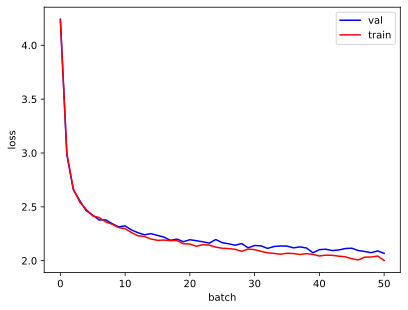

In [544]:
train_losses = np.array([float(l["train"]) for l in all_losses])
val_losses = np.array([float(l["val"]) for l in all_losses])
batches = np.arange(0, 51)

plt.plot(batches, val_losses, "b", label="val")
plt.plot(batches, train_losses, "r", label="train")
plt.legend()
plt.xlabel("batch")
plt.ylabel("loss")
plt.show()

In [509]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Thous and 'n whit; bip
Soour cawn and you, of of fier gnothere:
You.
Ye sbe theise a deavate?  we counturend it:
De.
I, Go me pre would. his bOy indestuze all meerusten seldaince:
Lossted of IOLIS:
Ouppace andser's, srey
His suurce would, and in knoweBuch fall of calpome tabe hus all ser wour lan frome.
Thee?
Thold me way beecood: upare yef:
Foum fore.

go-fio grome ith.

Uppcore; sir,
As A stanurm, andoll, word brottlon hour.
Him chall De Howar querse?

This m wat and of too of in fadin oue, as


In [510]:
import pandas as pd
words = "".join(filter(lambda c: c not in "!$&',-.3:;?'", text)).lower().split()
bigrams = [
    {
        "first": words[i],
        "second": words[i + 1],
        "count": 1,
    } 
    for i in range(len(words) - 1)
]
bigrams = (
    pd
    .DataFrame(bigrams)
    .groupby(["first", "second"])
    .agg(count=("count", "sum"))
    .reset_index()
)

firsts = (
    bigrams
    .groupby("first")
    .agg(total=("count", "sum"))
    .reset_index()
)

bigrams = pd.merge(
    left=bigrams,
    right=firsts,
    on="first",
    how="left",
)
bigrams["p"] = bigrams["count"] / bigrams["total"]

def sample(first: str, bigrams: pd.DataFrame) -> str:
    candidates = bigrams.query(f"first == '{first}'").sample(weights="p", n=1)
    return candidates["second"].tolist()[0]

output = ["the"]
for _ in tqdm.tqdm(range(250)):
    output.append(sample(output[-1], bigrams))
output = " ".join(output)
print(output)

  0%|          | 0/250 [00:00<?, ?it/s]

the king in and therefore use our insufficience may i say the third servingman so well touse you teach me as swift ambassador but bid it tell what drawn your more than you will my parks and royal grace and warm at stake drawn salt water his breast mine edward stands me amongst us aboard a brother die and desperately dispatchd for to beg of their pride ere this the commonwealth forgets the knaves you do entreat of the realm had scorchd the hard hearts ease petruchio haberdasher here at thy sovereigns face that mercy and plague o perilous mouths be with triumphant fathers blood of them and endless night go to have but with her own hand of my wife my boots that he he had been in truth and cannot anger of my fathers love the fire to marry a mans appetite lay fourteen of civil and kindly kissd her to in my brother were in rome as thou tell sad and puller down by the volsces plough rome sits here to add more power miranda i from montague speak warwick speak my sworn whose enmity prince edwar